In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.utils import shuffle
from IPython.display import clear_output

In [5]:
def flatten(X):
    N = X.shape[-1] #matlab is the last dim
    flat=np.zeros((N,32*32*3))
    for i in range(N):
        flat[i]=X[:,:,:,i].reshape(32*32*3)
    return flat



INFO:tensorflow:Scale of 0 disables regularizer.


In [14]:
train=loadmat('sample_images/train_32x32.mat')
test=loadmat('sample_images/test_32x32.mat')

Xtrain=flatten(train['X'].astype(np.float32)/255)
Ytrain=train['y'].flatten()-1

Xtest=flatten(test['X'].astype(np.float32)/255)
Ytest=test['y'].flatten()-1

n_epochs=100
N,D=Xtrain.shape
batch_sz=500
n_batches=N/batch_sz

n_hidden1=400
n_hidden2=n_hidden1//2
n_outputs=10

learning_rate=0.0005
scale=0.000
tf.reset_default_graph()
X=tf.placeholder(tf.float32,shape=(None,D),name="X")
y=tf.placeholder(tf.int64,shape=(None),name="y")

#apply l1 regularizer and he init method
from functools import partial
he_init = tf.contrib.layers.variance_scaling_initializer(mode="FAN_AVG") # he init method

my_dense=partial(tf.layers.dense,activation=tf.nn.elu,
                 kernel_regularizer=tf.contrib.layers.l1_regularizer(scale),
                 kernel_initializer=he_init)

with tf.name_scope("dnn"):
    dropout_rate=0.2
    training=tf.placeholder_with_default(False,shape=(),name="training")
    
    hidden1=my_dense(X,n_hidden1,name="hidden1",kernel_initializer=he_init,
                     activation=tf.nn.elu) #use ELU
    #dropout1
    hidden1_drop=tf.layers.dropout(hidden1,dropout_rate,training=training)

    hidden2=my_dense(hidden1_drop,n_hidden2,name="hidden2",
                     kernel_initializer=he_init,activation=tf.nn.elu) #ELU
    #dropout
    hidden2_drop=tf.layers.dropout(hidden2,dropout_rate,training=training)
    
    logits=my_dense(hidden2_drop,n_outputs, kernel_regularizer=tf.contrib.layers.l1_regularizer(scale),
                 kernel_initializer=he_init,name="outputs")

with tf.name_scope("loss"):
    xentropy=tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,logits=logits)
    loss=tf.reduce_mean(xentropy,name="loss")


with tf.name_scope("train"):
    optimizer=tf.train.RMSPropOptimizer(learning_rate=learning_rate)
    training_op=optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct=tf.nn.in_top_k(logits,y,1)
    accuracy=tf.reduce_mean(tf.cast(correct,tf.float32))
init=tf.global_variables_initializer()
saver=tf.train.Saver()


train_accuracy_save=[]
test_accuracy_save=[]
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        Xtrain,Ytrain=shuffle(Xtrain,Ytrain)
        for iteration in range(N//batch_sz):
            X_batch,y_batch=(Xtrain[iteration*batch_sz:(iteration*batch_sz+batch_sz),:],
                             Ytrain[iteration*batch_sz:(iteration*batch_sz+batch_sz)])
            sess.run(training_op,feed_dict={X:X_batch,y:y_batch,training:True}) # dropout=True
#         print(logits.eval(feed_dict={X:X_batch,y:y_batch}))
        acc_train=accuracy.eval(feed_dict={X:X_batch,y:y_batch}) # dropout=True
        acc_test=accuracy.eval(feed_dict={X:Xtest,y:Ytest})
        clear_output()
        print(epoch+1,"Train accuracy: ",acc_train," Test accuracy: ",acc_test,end="\r")
        train_accuracy_save.append(acc_train)
        test_accuracy_save.append(acc_test)
    save_path=saver.save(sess,"model_checkpoints/svhn_ann.ckpt")




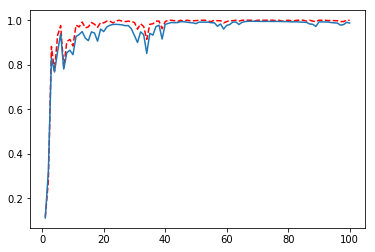

In [15]:
x_number=range(1,len(test_accuracy_save)+1)
plt.plot(x_number, train_accuracy_save, 'r--', x_number,test_accuracy_save)